## **Projeto 1 - Classificação de sinais de ECG no domínio original**

### **Grupo D:** Extração de features usando filtros de Chebyschev tipo I

### **Alunos:**
*   **Nome:** Josué Bezerra Bonfim Filho - **Matrícula:** 222100026
*   **Nome:** Tiago Rodrigues Pereira - **Matrícula:** 222100447

### **Objetivo:**
Utilizando cerca de 800 sinais de ECG, o objetivo deste projeto é classifica-los em 2 classes: normal ou com anomalia (SVT - Supraventricular Tachycardia). Para isso, serão extraídas características de cada sinal em janelas constantes e utilizadas para treinar um classificador supervisionado tipo MLP (Multi-Layer Perceptron).

### **Descrição do dataset:**
*  **Número de sinais:**
    *   Normal: X
    *   SVT: Y
*  **Duração de cada sinal:** 10 segundos
*  **Frequência de amostragem:** 500 Hz
*  **Número de canais:** 12

### **Descrição do pré-processamento:**
*   **Filtro de Chebyschev tipo I:** 
    *   **Ordem:** X
    *   **Frequências de corte:** Y Hz
    *   **Tipos de filtro:** Passa-baixas
    *   **Frequência de amostragem:** Z

### **Descrição da extração de features:**
*   **Janelas:** 
    *   **Tamanho:** X segundos
*   **Características extraídas:**
    - Média de RR
    - Média de QR
    - Média de RS
    - Relação R/S
    - Relação R/Q

### Parte 1 - Importação das bibliotecas e funções

In [4]:
# Importando bibliotecas
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import firwin, butter, lfilter, cheby1
from pathlib import Path

In [5]:
# Carregando dados de ECG selecionados
# 1. Definindo caminho para os dados
datapath = '../../../../_aulas/aula1/files/ECGData/'
datapath1 = 'selected_signals_org'
# 2. Carregando dataframe com o nome dos arquivos da classe normal
df_normal1 = pd.read_csv(datapath1 + '/good_signals0to199.csv')
df_normal2 = pd.read_csv(datapath1 + '/good_signals200to399.csv')
df_normal = pd.concat([df_normal1, df_normal2], ignore_index=True)
# 3. Carregando dataframe com o nome dos arquivos da classe de arritmia
df_arritmia = pd.read_csv('goodSignals_SVT.csv')
df_arritmia = df_arritmia.rename(columns={'Nome': 'FileName'})
df_arritmia = df_arritmia.drop(columns=['N°', 'Rótulo'])
# Printando o número de arquivos em cada classe
print('Número de arquivos da classe normal: ', len(df_normal))
print('Número de arquivos da classe de arritmia: ', len(df_arritmia))

Número de arquivos da classe normal:  268
Número de arquivos da classe de arritmia:  283


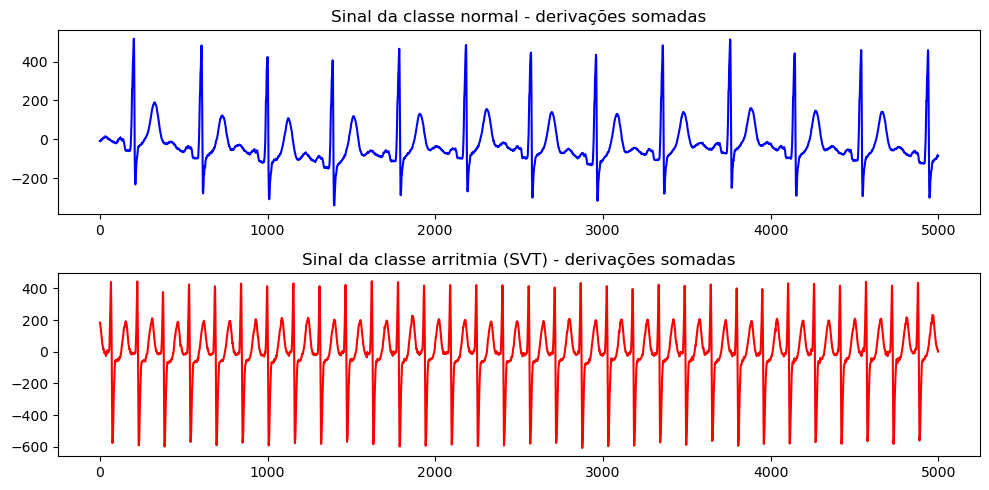

In [6]:
# Plotando um sinal aleatório de cada classe
# 1. Definindo um seed aleatório para reprodução dos resultados
np.random.seed(42)
# 2. Selecionando um sinal aleatório da classe normal
idx_normal = np.random.randint(0, len(df_normal))
file_normal = df_normal.iloc[idx_normal]['FileName']
ecg_normal = pd.read_csv(datapath + file_normal + '.csv')
ecgSum_normal = ecg_normal.mean(axis=1)
# 3. Selecionando um sinal aleatório da classe arritmia
idx_arritmia = np.random.randint(0, len(df_arritmia))
file_arritmia = df_arritmia.iloc[idx_arritmia]['FileName']
ecg_arritmia = pd.read_csv(datapath + file_arritmia + '.csv')
ecgSum_arritmia = ecg_arritmia.mean(axis=1)
# 4. Plotando os sinais
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(ecgSum_normal, color='b')
axs[0].set_title('Sinal da classe normal - derivações somadas')
axs[1].plot(ecgSum_arritmia, color='r')
axs[1].set_title('Sinal da classe arritmia (SVT) - derivações somadas')
plt.tight_layout()
plt.show()

### Detecao dos picos QRS

#### Filtros usados:
* Chebyschev 1

In [39]:
import matplotlib.gridspec as matgrid

def pre_process(x, fs = 500,freqs_notch = 188, freq_highpass = 1 , freq_lowpass = 245, freqs_qrs = [8, 12], duracao_minimia_deteccao_r = 0.025, tipo_filtro = 'cheby1', ordem_filtro = 2):
    y = x
    fig = plt.figure()
    gs = matgrid.GridSpec(2,2)
    ax = fig.add_subplot(gs[0, :])
    t = np.linspace(1500, 2500, 1000)/500
    ax.plot(t, y[1500:2500])
    ax.set_ylabel("Amplitude do Sinal")
    ax.set_xlabel(r'Tempo em [$s$]')
    plt.grid()
    #plot de y_hat
    y_hat = np.fft.fft(y)[:len(y)//2]
    f = np.linspace(0, 0.5, len(y_hat)) * fs
    ax = fig.add_subplot(gs[1, :])
    ax.plot(f, np.abs(y_hat))
    ax.set_ylabel("Magnitude da transformada\nde Fourier do Sinal")
    ax.set_xlabel(r'Frequência em [$Hz$]')
    plt.tight_layout()
    plt.grid()
    plt.savefig("original.png")
    plt.clf()
    
    y = notch(y, ordem_filtro, freqs_notch, fs)
    #plot do Y
    fig = plt.figure()
    gs = matgrid.GridSpec(2,2)
    ax = fig.add_subplot(gs[0, :])
    t = np.linspace(1500, 2500, 1000)/500
    ax.plot(t, y[1500:2500])
    ax.set_ylabel("Amplitude do Sinal")
    ax.set_xlabel(r'Tempo em [$s$]')
    plt.grid()
    #plot de y_hat
    y_hat = np.fft.fft(y)[:len(y)//2]
    f = np.linspace(0, 0.5, len(y_hat)) * fs
    ax = fig.add_subplot(gs[1, :])
    ax.plot(f, np.abs(y_hat))
    ax.set_ylabel("Magnitude da transformada\nde Fourier do Sinal")
    ax.set_xlabel(r'Frequência em [$Hz$]')
    plt.tight_layout()
    plt.grid()
    plt.savefig("notch.png")
    plt.clf()
    
    y = passa_baixas(y, ordem_filtro, freq_lowpass, fs)
    fig = plt.figure()
    gs = matgrid.GridSpec(2,2)
    ax = fig.add_subplot(gs[0, :])
    t = np.linspace(1500, 2500, 1000)/500
    ax.plot(t, y[1500:2500])
    ax.set_ylabel("Amplitude do Sinal")
    ax.set_xlabel(r'Tempo em [$s$]')
    plt.grid()
    #plot de y_hat
    y_hat = np.fft.fft(y)[:len(y)//2]
    f = np.linspace(0, 0.5, len(y_hat)) * fs
    ax = fig.add_subplot(gs[1, :])
    ax.plot(f, np.abs(y_hat))
    ax.set_ylabel("Magnitude da transformada\nde Fourier do Sinal")
    ax.set_xlabel(r'Frequência em [$Hz$]')
    plt.tight_layout()
    plt.grid()
    plt.savefig("passa_baixas.png")
    plt.clf()
    
    y = passa_altas(y, ordem_filtro, freq_highpass, fs)
    fig = plt.figure()
    gs = matgrid.GridSpec(2,2)
    ax = fig.add_subplot(gs[0, :])
    t = np.linspace(1500, 2500, 1000)/500
    ax.plot(t, y[1500:2500])
    ax.set_ylabel("Amplitude do Sinal")
    ax.set_xlabel(r'Tempo em [$s$]')
    plt.grid()
    #plot de y_hat
    y_hat = np.fft.fft(y)[:len(y)//2]
    f = np.linspace(0, 0.5, len(y_hat)) * fs
    ax = fig.add_subplot(gs[1, :])
    ax.plot(f, np.abs(y_hat))
    ax.set_ylabel("Magnitude da transformada\nde Fourier do Sinal")
    ax.set_xlabel(r'Frequência em [$Hz$]')
    plt.tight_layout()
    plt.grid()
    plt.savefig("passa_altas.png")
    plt.clf()
    
    y = passa_faixa(y, ordem_filtro, 10,fs)
    fig = plt.figure()
    gs = matgrid.GridSpec(2,2)
    ax = fig.add_subplot(gs[0, :])
    t = np.linspace(1500, 2500, 1000)/500
    ax.plot(t, y[1500:2500])
    ax.set_ylabel("Amplitude do Sinal")
    ax.set_xlabel(r'Tempo em [$s$]')
    plt.grid()
    #plot de y_hat
    y_hat = np.fft.fft(y)[:len(y)//2]
    f = np.linspace(0, 0.5, len(y_hat)) * fs
    ax = fig.add_subplot(gs[1, :])
    ax.plot(f, np.abs(y_hat))
    ax.set_ylabel("Magnitude da transformada\nde Fourier do Sinal")
    ax.set_xlabel(r'Frequência em [$Hz$]')
    plt.tight_layout()
    plt.grid()
    plt.savefig("passa_faixas.png")
    plt.clf()
    return y

def notch(x, ordem_filtro, freq, fs):
    b, a = cheby1(ordem_filtro, 1, [freq-4, freq+4], btype="bandstop", fs = fs)
    y = lfilter(b, a, x)
    return y 

def passa_baixas(x, ordem_filtro, freq, fs):
    b, a = cheby1(ordem_filtro, 1, freq, btype="lowpass", fs = fs)
    y = lfilter(b, a, x)
    return y 

def passa_altas(x, ordem_filtro, freq, fs):
    b, a = cheby1(ordem_filtro, 1, freq, btype="highpass", fs = fs)
    y = lfilter(b, a, x)    
    return y 

def passa_faixa(x, ordem_filtro, freq, fs):
    banda_rejeicao = np.array([freq - 2, freq + 20])
    b, a = cheby1(ordem_filtro, 1, banda_rejeicao, btype="bandpass", fs = fs)
    y = lfilter(b, a, x)
    return y 


In [31]:
def deteccao_qrs(x, y):
    y = y[1: ] - y[:-1]
    M = np.max(np.abs(y))
    k = np.where(np.abs(y) > 0.6 * M)[0] # índices dos valores de X que ultrapassam o threshold
    sign_y = np.sign(y[k])
    mudanca_sinal_derivada = sign_y[1 :] - sign_y[:-1]
    k2 = np.where(mudanca_sinal_derivada == 2)[0] # índicies dos valores de x[k] que rolou a inversao de derivada
    k3 = np.where(mudanca_sinal_derivada == -2)[0]
    
    
    #Detecção do pico R
    for i in range (len(k3)):
        index = k[k3[i]]
        interval = x[index - 15 : index + 15]
        index_max = np.where(interval == np.max(interval))[0]
        k[k3[i]] = k[k3[i]] + np.argmax(interval) - 15
    picoR = k[k3]
    
    for i in range(len(picoR)):
        interval = x[picoR[i] - 20 : picoR[i] + 20]
        picoR_temp = np.argmax(interval) - 20
        picoR[i] += picoR_temp
    print(picoR)
            
        

    #deteccao do pico S e do pico Q
    picoS = []
    picoQ = []
    for i in range(len(picoR)):
        interval = x[picoR[i]: picoR[i] + 100]
        picoS.append(picoR[i] + np.argmin(interval))
        if(picoR[i] - 50 > 0):
            interval = x[picoR[i] - 50 : picoR[i]]
            picoQ.append(picoR[i] - 50 + np.argmin(interval))
        else:
            picoQ.append(0)
        
    return picoR, picoS, picoQ, k

[ 202  606 1000 1388 1785 2183 2571 2959 3357 3759 4144 4540]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

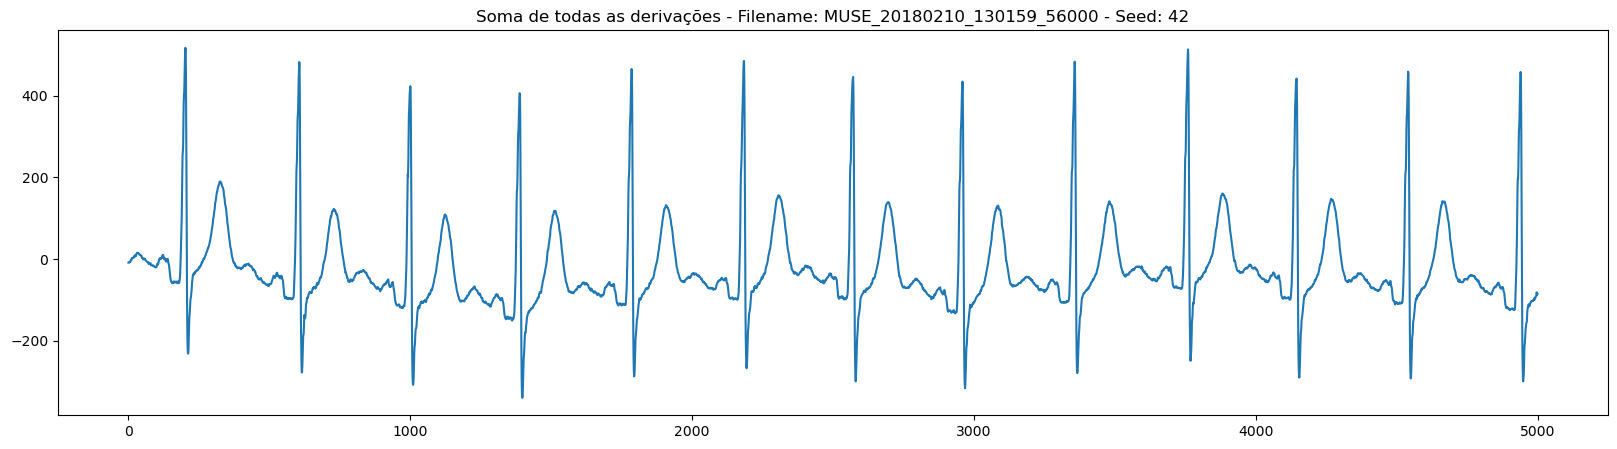

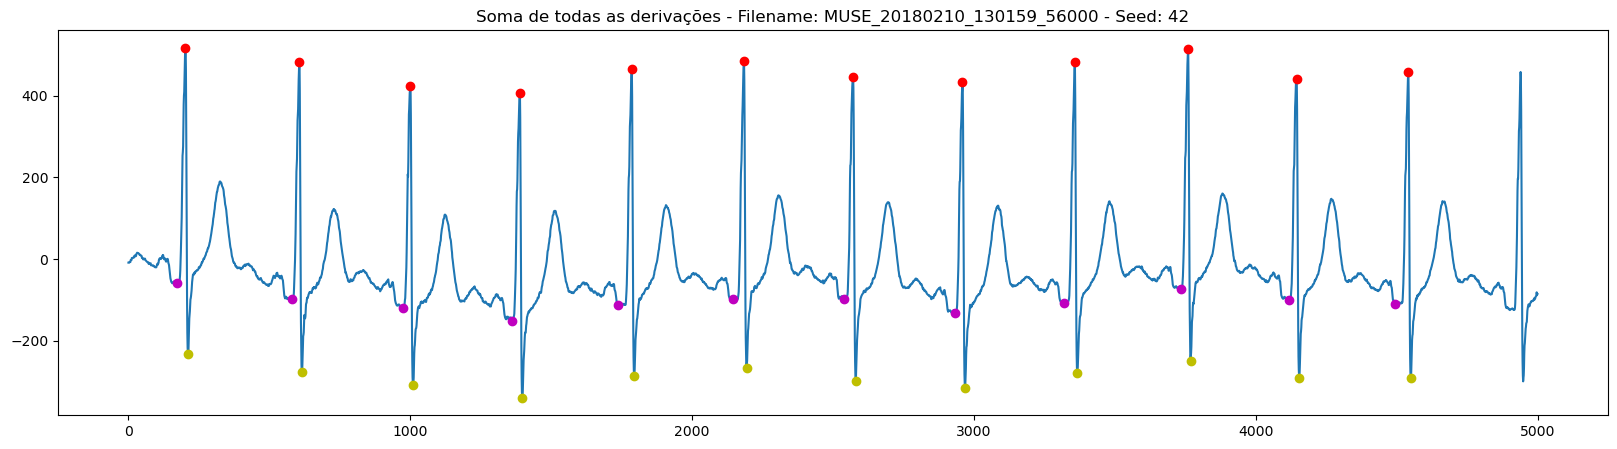

In [40]:
if __name__ == '__main__':
    # Aplica dos filtros e detecao do pico R
    x = ecgSum_normal
    # Frequência de amostragem
    fs = 500
    # Detecao de picos QRS
    
    # Pré processamento do sinal. 
    y = pre_process(x, fs = fs)
    
    picoR, picoS, picoQ, k = deteccao_qrs(x, y)
    plt.figure(figsize=(20, 5))
    plt.title('Soma de todas as derivações - Filename: ' + file_normal + ' - Seed: ' + str(42))
    plt.plot(x)
    plt.figure(figsize=(20, 5))
    plt.plot(x)
    plt.title('Soma de todas as derivações - Filename: ' + file_normal + ' - Seed: ' + str(42))
    plt.plot(picoQ, x[picoQ], 'om', label='Q')
    plt.plot(picoR, x[picoR], 'or', label='R')
    plt.plot(picoS, x[picoS], 'oy', label='S')

In [10]:
# Função de extração de características
def extract_features(x, ref_r_loc, ref_q_loc, ref_s_loc, tamanho_janela, signal_class, filename, fs):
    # Calcula o tamanho da janela
    tamanho_janela = int(tamanho_janela * fs)
    # Define a matriz de saída com zeros
    qrs_features = np.zeros(shape=(int(len(x)/tamanho_janela), 6), dtype=float)
    # Define o vetor de saída com zeros com índice do participante paras as janelas
    qrs_participant = np.zeros(shape=(int(len(x)/tamanho_janela), 1), dtype=int)
    # Define o vetor de saída com zeros do índice do participante + nome do arquivo
    # qrs_filename = np.zeros(shape=(int(len(x)/tamanho_janela + 1), 2), dtype=[('id', 'int'), ('filename', 'str')])
    qrs_filename = []
    # Define possíveis indices de corte com base nas posições de Se o próximo Q
    indice_corte_list = [int(np.mean([s, q])) for s, q in zip(ref_s_loc[:-1], ref_q_loc[1:])]
    # Define o último índice de corte
    indice_corte_list.append(len(x))
    # print('corte_list: ' + str(indice_corte_list))
    # Define lista final de índices de corte
    indice_corte_final = [0]
    # Define índices de corte com base no tamanho da janela
    for i in range(int(len(x)/tamanho_janela)):
        dif = np.abs(np.array(indice_corte_list) - (i + 1) * tamanho_janela)
        indice_corte_final.append(indice_corte_list[np.where(dif == np.min(dif))[0][0]])
    # print('corte_final: ' + str(indice_corte_final))
    # Realiza a extração de características
    # print('r_loc: ' + str(ref_r_loc))
    for i in range(int(len(x)/tamanho_janela)):
        # # Cria sinal janelado
        # print([indice_corte_final[i], indice_corte_final[i + 1]])
        # x_janelado = x[indice_corte_final[i]:indice_corte_final[i + 1]]
        # # Plotando o sinal e os picos
        # plt.figure(figsize=(20, 5))
        # plt.title('Janela ' + str(i) + ' para tamanho de ' + str(int(tamanho_janela/fs)) + ' segundos - Filename: ' + filename + ' - Seed: ' + str(seed))
        # plt.plot(x_janelado)
        # Limitando o número de picos para apenas os dentro da janela
        r_loc_janela = [x for x in ref_r_loc if indice_corte_final[i] <= x <= indice_corte_final[i + 1]]
        q_loc_janela = [x for x in ref_q_loc if indice_corte_final[i] <= x <= indice_corte_final[i + 1]]
        s_loc_janela = [x for x in ref_s_loc if indice_corte_final[i] <= x <= indice_corte_final[i + 1]]
        # p_loc_janela = [x for x in ref_p_loc if indice_corte_final[i] <= x <= indice_corte_final[i + 1]]
        # t_loc_janela = [x for x in ref_t_loc if indice_corte_final[i] <= x <= indice_corte_final[i + 1]]
        # Uniformizando o tamanho de P e T
        # print('P: '+ str(p_loc_janela))
        # print('T: '+ str(t_loc_janela))
        # print('R: '+ str(len(r_loc_janela)))
        # p_loc_janela = [p_loc_janela[i] if i < len(p_loc_janela) else 0 for i in range(len(r_loc_janela))]
        # t_loc_janela = [t_loc_janela[i] if i < len(t_loc_janela) else 0 for i in range(len(r_loc_janela))]
        # print('P: '+ str(p_loc_janela))
        # print('T: '+ str(t_loc_janela))
        # if len(p_loc_janela) < len(r_loc_janela):
        #     p_loc_janela = [0] * p_loc_janela[:len(r_loc_janela)]
        # elif len(t_loc_janela) < len(r_loc_janela):
        #     t_loc_janela = t_loc_janela[:len(r_loc_janela)]
        # Printa o tamanho de todos os picos
        # print([len(r_loc_janela), len(q_loc_janela), len(s_loc_janela), len(p_loc_janela), len(t_loc_janela)])
        # Calculo da média entre intervalos RR
        # Caso tamanho de R seja menor que 2, não calcula:
        if len(r_loc_janela) < 2:
            # Calcula a janela anterior
            r_loc_janela_ant = [x for x in ref_r_loc if indice_corte_final[i - 1] <= x <= indice_corte_final[i]]
            # Calcula o intervalo RR entre o último índice da janela anterior e a atual
            print(len(r_loc_janela_ant))
            print(len(r_loc_janela))
            print(r_loc_janela_ant)
            print(r_loc_janela)
            qrs_features[i, 0] = np.mean(np.subtract(r_loc_janela, r_loc_janela_ant[-1]))
        else:
            qrs_features[i, 0] = np.mean(np.diff(r_loc_janela))
        # if len(q_loc_janela) == len(r_loc_janela):
        # Calculo da média entre intervalos QR
        qrs_features[i, 1] = np.mean(np.subtract(r_loc_janela, q_loc_janela))
        # Cálculo da relação entre picos R/Q
        qrs_features[i, 3] = np.mean(np.divide(np.abs(x[r_loc_janela]), np.abs(x[q_loc_janela])))
        # if len(s_loc_janela) == len(r_loc_janela):
        # Calculo da média entre intervalos RS
        qrs_features[i, 2] = np.mean(np.subtract(s_loc_janela, r_loc_janela))
        # Cálculo da relação entre picos R/S
        qrs_features[i, 4] = np.mean(np.divide(np.abs(x[r_loc_janela]), np.abs(x[s_loc_janela])))
        # if len(t_loc_janela) == len(s_loc_janela):
        # Calculo da média entre intervalos ST
        # qrs_features[i, 3] = np.mean(np.subtract(t_loc_janela, s_loc_janela))
        # if len(t_loc_janela) == len(p_loc_janela):
        # Calculo da média entre intervalos TP
        # qrs_features[i, 4] = np.mean(np.subtract(t_loc_janela, p_loc_janela))
        # if len(r_loc_janela) == len(t_loc_janela):
        # Cálculo da relação entre picos R/T
        # qrs_features[i, 7] = np.mean(np.divide(np.abs(x[r_loc_janela]), np.abs(x[t_loc_janela])))
        # if len(r_loc_janela) == len(p_loc_janela):
        # Cálculo da relação entre picos R/P
        # qrs_features[i, 8] = np.mean(np.divide(np.abs(x[r_loc_janela]), np.abs(x[p_loc_janela])))
        # Calcula quantidade de QRS pela quantidade de R
        qrs_count = len(r_loc_janela)
        qrs_features[i, 5] = qrs_count
        # Registra o índice do participante
        qrs_participant[i] = signal_class
        # Cria um vetor de referência para participante
        qrs_filename.append([filename, signal_class])

    

    # Retorna a matriz de características e o vetor de índices do participante
    return qrs_features, qrs_participant, qrs_filename

In [20]:
# Testa a função de extração de características
qrs_features, qrs_participant, qrs_filename = extract_features(x, picoR, picoQ, picoS, 5, 42, file_normal, fs)
print(qrs_features)
print(qrs_participant)
print(qrs_filename)

[[396.2         32.           9.66666667   4.80480621   1.6610163
    6.        ]
 [393.8         32.16666667   9.16666667   4.64935455   1.62346109
    6.        ]]
[[42]
 [42]]
[['MUSE_20180210_130159_56000', 42], ['MUSE_20180210_130159_56000', 42]]


In [28]:
# Extraindo características para todos os sinais
# Cria um dataframe para armazenar as características
qrs_features_df = pd.DataFrame(columns=['mean_rr', 'mean_qr', 'mean_rs', \
                                        'mean_r_s', 'mean_r_q', 'qrs_count'])
# Cria um dataframe para armazenar os rotulos dos sinais
qrs_class_df = pd.DataFrame(columns=['class'])
# Cria um dataframe para armazenar erros
qrs_error_df = pd.DataFrame(columns=['filename', 'error'])
# Configurações
fs = 500
# Realiza a extração de características para todos os sinais
filename_list = []
# Loop para ambas as classes, 0 = normal, 1 = arritmia (SVT)
for signal_class in [0, 1]:
    # Loop para todos os arquivos
    for i in range(len(df_normal)):
        # Printa o nome do arquivo
        match signal_class:
            case 0:
                filename = df_normal.iloc[i][0]
                rotulo = 0
            case 1:
                filename = df_arritmia.iloc[i][0]
                rotulo = 1
        # print(str(i) + ' - ' + filename)
        # Verifica se todos os sinais estão sendo interados
        filename_list.append(filename)
        # Corta o dataframe para o sinal atual
        data = pd.read_csv(datapath + filename + '.csv')
        # Soma da média de todas as derivações
        x = data.mean(axis=1).values
        # Seleciona a derivação II
        # x = data['II'].values
        # # Plota o sinal
        # plt.figure(figsize=(20, 5))
        # plt.title('Derivação II - Filename: ' + filename)
        # plt.plot(x)
        # # Para o loop com uma tecla
        # input('Pressione qualquer tecla para continuar...')
        try:
            # Detecao de picos QRS
            # y, k, max_indices, r_loc, s_loc, q_loc = deteccao_qrs(x)
            # # Define o tamanho da janela de análise de P e T com base na quantidade de qrs
            # qrs_count = len(r_loc)
            # tp_window = int(3 * fs / qrs_count)
            # # print(tp_window)
            # # Refina localizacao dos picos QRS e encontra picos P e T
            # ref_r_loc, ref_q_loc, ref_s_loc = refine_qrs_locations(q_loc, r_loc, s_loc, x, tp_window)
            y = pre_process(x)
            picoR, picoS, picoQ, k = deteccao_qrs(x, y)
        # Carro error no refinamento dos picos
        except (ValueError) as err:
            print('ValueError aconteceu no arquivo: ' + str(filename))
            qrs_error_df = pd.concat([qrs_error_df, pd.DataFrame([[filename, err]], columns=qrs_error_df.columns)], ignore_index=True)
            print('Progresso: ' + str(i) + '/' + str(len(df_normal)))
        else:
            try: 
                # Extrai as características
                qrs_features, qrs_class, _ = extract_features(x, picoR, picoQ, picoS, 5, rotulo, filename, fs)
                # print(np.shape(qrs_filename))
            except (IndexError, ValueError) as err:
                print('Error aconteceu no arquivo: ' + str(filename))
                qrs_error_df = pd.concat([qrs_error_df, pd.DataFrame([[filename, err]], columns=qrs_error_df.columns)], ignore_index=True)
                print('Progresso: ' + str(i) + '/' + str(len(df_normal)))
                pass
            else:
                # Adiciona as características ao dataframe
                qrs_features_df = pd.concat([qrs_features_df, pd.DataFrame(qrs_features, columns=qrs_features_df.columns)], ignore_index=True)
                # Adiciona os índices dos participantes ao dataframe
                qrs_class_df = pd.concat([qrs_class_df, pd.DataFrame(qrs_class, columns=qrs_class_df.columns)], ignore_index=True)
                # Printa o progresso
                print('Progresso: ' + str(i) + '/' + str(len(df_normal) - 1))
    qrs_features_df = pd.concat([qrs_features_df, pd.DataFrame(qrs_features, columns=qrs_features_df.columns)], ignore_index=True)
    qrs_class_df = pd.concat([qrs_class_df, pd.DataFrame(qrs_class, columns=qrs_class_df.columns)], ignore_index=True)
# Printa o uso de memória da célula
# %load_ext memory_profiler
# %memit
# Salva os dataframes
qrs_features_df.to_csv('qrs_features_df.csv')
qrs_class_df.to_csv('qrs_class_df.csv')
qrs_error_df.to_csv('qrs_error_df.csv')


[ 374  761 1105 1555 1897 2340 2673 3059 3446 3886 4222]
Progresso: 0/267
[ 287  689 1092 1495 1888 2283 2685 3089 3492 3898 4296]
Progresso: 1/267
[ 234  650 1063 1482 1904 2323 2738 3161 3589 4020 4452]
Progresso: 2/267
[  90  503  890 1258 1642 2030 2411 2776 3139 3519 3905 4277]
Progresso: 3/267
[ 316  779 1252 1714 2166 2631 3102 3557 4003 4465]
Progresso: 4/267
[ 128  498  871 1239 1625 2022 2437 2854 3260 3677 4102 4532]
Progresso: 5/267
[ 232  664 1081 1489 1897 2302 2715 3109 3504 3911 4326]
Progresso: 6/267
[ 208  649 1094 1549 1987 2411 2840 3287 3751 4194]
Progresso: 7/267
[ 230  589  947 1303 1663 2025 2383 2737 3092 3449 3806 4162 4516]
Progresso: 8/267
[ 298  613  932 1247 1564 1884 2203 2522 2839 3156 3475 3793 4109 4424]
Progresso: 9/267
[1091 1427 1763 2102 3161 3509 3856]
Progresso: 10/267
[ 198  533  868 1203 1540 1877 2216 2555 2895 3232 3564 3895 4220 4544]
Progresso: 11/267
[ 371  706 1015 1375 1726 2128 2411 2803 3144 3430 3763 4146 4470]
Progresso: 12/267
[  15

/var/folders/_q/020n0qks30jbyk91vj918f_40000gn/T/ipykernel_36609/3840989610.py:71: RuntimeWarning: divide by zero encountered in divide
  qrs_features[i, 3] = np.mean(np.divide(np.abs(x[r_loc_janela]), np.abs(x[q_loc_janela])))


ValueError aconteceu no arquivo: MUSE_20180114_065449_49000
Progresso: 63/268
[]
0
0
[]
[]
Error aconteceu no arquivo: MUSE_20180114_070036_90000
Progresso: 64/268
[ 120  344  565  786 1007 1228 1448 1670 1891 2112 2333 2554 2774 2993
 3214 3434 3653 3873 4091 4312 4531 4751]
Progresso: 65/267
[  96  285  486  701 1009 1206 1402 1590 1781 1970 2162 2353 2545 2734
 2924 3113 3301 3487 3676 3862 4048 4234 4422 4610 4800]
Progresso: 66/267
[  62  257  453  650  846 1044 1241 1438 1634 1830 2026 2222 2419 2616
 2814 3011 3206 3400 3594 3793 3990 4187 4384 4580 4775]
Progresso: 67/267
[ 418  621 1025 1831 2035 2237 2841 3044 3248 3451 4255 4457 4659]
Progresso: 68/267
ValueError aconteceu no arquivo: MUSE_20180114_074335_52000
Progresso: 69/268
ValueError aconteceu no arquivo: MUSE_20180114_074746_87000
Progresso: 70/268
[  95  269  442  615  789  962 1135 1308 1482 1655 1829 2003 2176 2350
 2523 2696 2870 3043 3216 3389 3563 3735 3908 4081 4254 4428 4601 4774]
Progresso: 71/267
[ 179  357 

In [29]:
# Printa o tamanho dos dataframes
print('Tamanho do dataframe de características: ' + str(qrs_features_df.shape))
print('Tamanho do dataframe de rotulo: ' + str(qrs_class_df.shape))
qrs_class_df.head()


Tamanho do dataframe de características: (990, 6)
Tamanho do dataframe de rotulo: (990, 1)


,class
0,0
1,0
2,0
3,0
4,0


In [30]:
qrs_class_df.tail()

,class
985,1
986,1
987,1
988,1
989,1
